<a href="https://colab.research.google.com/github/Heba2424/DEPI_Projects/blob/main/Time_series_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv('/content/Dataset1_Cleaned.csv')
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3647 entries, 0 to 3646
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3647 non-null   object 
 1   Temp    3647 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.1+ KB


In [ ]:
df.describe()

,Temp
count,3647.000000
mean,11.177214
std,4.072706
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [ ]:
df.isnull().sum()

,0
Date,0
Temp,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Parse dates
df['Date'] = pd.to_datetime(df['Date'])

# Set the date as the index
df.set_index('Date', inplace=True)

# Normalize the temperature values
scaler = MinMaxScaler(feature_range=(0, 1))
df['Temp'] = scaler.fit_transform(df[['Temp']])

In [ ]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

seq_length = 30  # For example, using the past 30 days to predict the next day
sequences, targets = create_sequences(df['Temp'].values, seq_length)

# Split the data into training and test sets
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]


In [ ]:
X_train.shape

(2893, 30)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.0555 - val_loss: 0.0120
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0134 - val_loss: 0.0118
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0136 - val_loss: 0.0115
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - loss: 0.0127 - val_loss: 0.0117
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0127 - val_loss: 0.0117
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0131 - val_loss: 0.0113
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - loss: 0.0128 - val_loss: 0.0124
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0123 - val_loss: 0.0119
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 0.0121 - val_loss: 0.0117
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0120 - val_loss: 0.0109
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0124 - val_loss: 0.0113
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - loss: 0.0128 -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0068
Test Loss: 0.007294237148016691
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


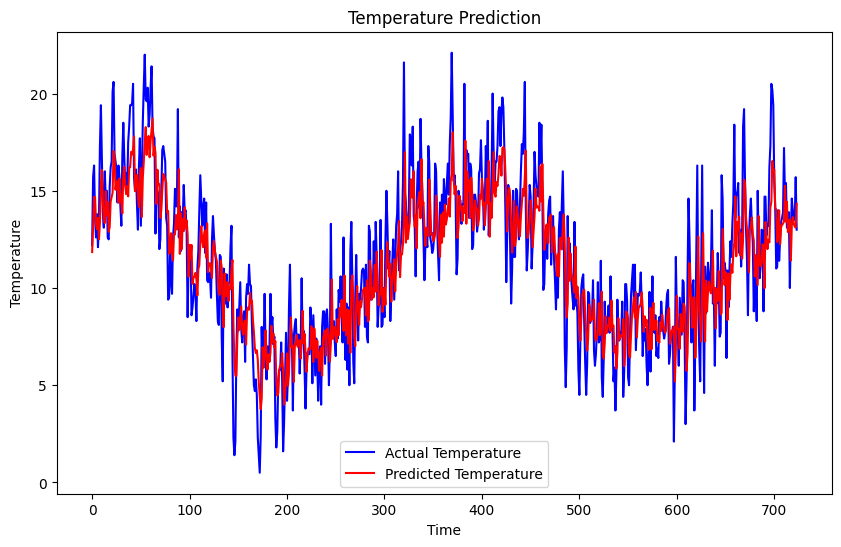

In [ ]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and true values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, color='blue', label='Actual Temperature')
plt.plot(predictions, color='red', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


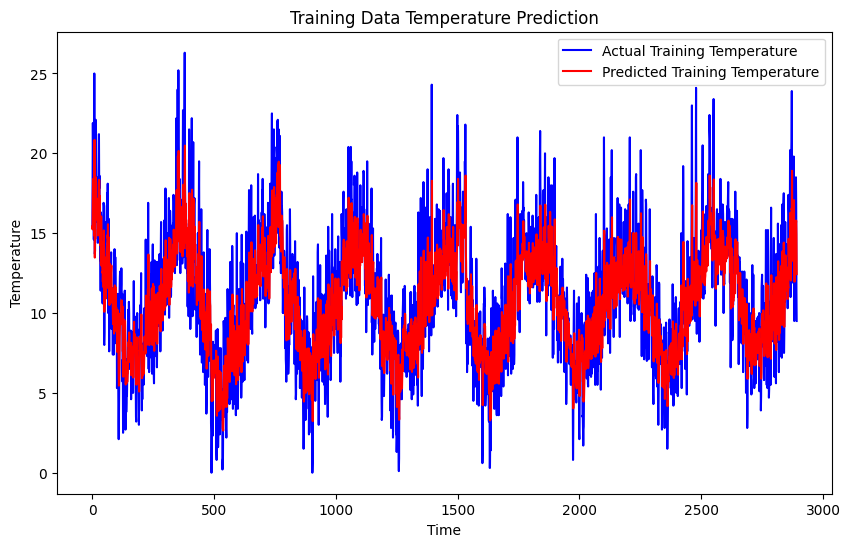

In [ ]:
# Make predictions
train_predictions = model.predict(X_train)

# Inverse transform the predictions and true values
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot the training results
plt.figure(figsize=(10, 6))
plt.plot(y_train, color='blue', label='Actual Training Temperature')
plt.plot(train_predictions, color='red', label='Predicted Training Temperature')
plt.title('Training Data Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [ ]:
# Make predictions on training data
train_predictions = model.predict(X_train)

# Inverse transform the training predictions and true values
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions on test data
test_predictions = model.predict(X_test)

# Inverse transform the test predictions and true values
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


# Plot the results with subplots
plt.figure(figsize=(14, 12))

# Plot training results
plt.subplot(2, 1, 1)
plt.plot(y_train, color='blue', label='Actual Training Temperature')
plt.plot(train_predictions, color='cyan', label='Predicted Training Temperature')
plt.title('Training Data Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()


# Plot test results
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, color='blue', label='Actual Test Temperature')
plt.plot(np.arange(len(y_train), len(y_train) + len(test_predictions)), test_predictions, color='orange', label='Predicted Test Temperature')
plt.title('Test Data Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()

plt.tight_layout()
plt.show()


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


ValueError: Cannot take the length of shape with unknown rank.